# Data Science Project 


I decided to take this opportunity to use what I learned in this course to redo some analysis I did for a project that has stagnated and I really need to finish.There are a couple things I hope to get from this.:

1. My original code was quite messy. I am hoping to clean it up using some of the tools from this course.
2. I want to be sure that I can replicate my results. 
3. I want to compare my models performance to NMF learned in this course.
4. I want to set up google cloud console, github, and binder so that my code can be made available for reproducibility

It should be noted that the functions "sensoryFunctionOptimizer(x0)" and "preferenceFunctionOptimizer(x0)" were part of a single function that was written and implemented prior to this project. However, these two functions needed to be adapted significantly for this project. All other work here is novel (including preparation of the data for analysis).

## Introduction to the model


This data comes from a collaboration with dynamical neuroscience (my department), computer science and physics departments. The physics department will be sending a probe into deep space to take photos of planets. The probe will have limited memory and will lose contact with earth for extended periods of time. Therefore, the probe will need to decide on its own what images to keep and send back to earth and what images to delete. The role of the computer scientists is to build a machine learning algorithm to make this decision. However, the ML algorithm needs to know what humans think would be important images to keep and which ones to delete. 

This led to us create a model (extend a similar already existing unidimensional model to multiple dimensions, see Ashby and Ennis) that assumes participants use sensory information to make liking judgements. 

The model assumes that each items location in sensory space is represented by a sensory multidimensional normal distribution (SMVN). Additionally, the model also assumes that there exists an 'ideal' multivariate normal distribution (IMVN) that represents the 'ideal' items location in sensory space. When considering a rating on the sensory dimension, the subjects perception is represented as a sample from the SMVN. Additionally, the subject lies down 6 criteria on the sensory dimension (creating 7 bins). Each bin is associated with a rating from 1-7 that increases with magnitude on the sensory dimension (i.e. with 1 representing the bin from the first criterion to negative infinity and 7 representing the bin from the sixth criterion to positive infinity). The subject determines the bin that it's sensory perception falls in and reports that rating. When a liking judgement is required, the subject imagines their ideal item (represented as a sample from the ideal MVN) and they compare the distance between the perceived item (sample) and the ideal sample. Once again the subject lays down 6 criteria but this time on a "distance" dimension (distance between perceived item and ideal). If the perceived item falls within the bin closest to the peak of the ideal distribution then the subject will rate it a 7. Alternatively, if the perceived item falls in the bin between the furthest criteria and infinity then the subject will rate it a 1.

Consider a simple one-dimensional example (shown in the figure below). Participants are presented with a number of cups of coffee, all varying on one dimenion - bitterness (sensory magnitude). When presented with a cup of coffee the participants are asked to provide two ratings from 1-7: a bitterness judgement and a liking judgement. The model assumes that the participants perception of bitterness is a sample from a univariate normal distribution. In the figure, x represents a specific sample located at -1.8 and this sample falls into the bin between criteria such and such and therefore the cup of coffee is rated a four (moderate) on bitterness. Furthermore, the model assumes the participant represents the ideal cup of coffee as a sample from unidimensional distribution on bitterness. In the figure, y represents a specific sample located at 1.5. The subject then computes the absolute difference between the two samples (percept and ideal). The distribution of these differences is shown in figure 1c which is folded univariate normal distribution. The criteria lie on this difference dimension and the participants reported liking rating reflects the bin that the computed difference falls within. 

In the following section I will fit the model to the multidimensional case. In this experiment, 27 participants reported 2 sensory and 2 liking ratings for each of 20 planets on 6 dimensions (Water, Clouds, Rings, Moons, Blue-green color, Red-yellow color). This resulted in 56 liking judgements for each dimension and liking (here, I treat each rating as if it came from a different subject, the effect of this will need to be established in future work). This results in two data matrices: a sensory matrix which is 20 (planets) * 6 (sensory dimensions) * 7 (rating) and a liking matrix which is 20 (planets) * 7 (ratings). Each cell in the matrix reports the frequency with which the rating was chosen on that dimension for that planet. In order to fit the model, I chose to first fit the sensory parameters to the sensory data matrix. Then I fixed the sensory parameters and fit the additional liking parameters to the liking data matrix.

The sensory parameters consist of:

- 114 means (19 planets * 6 dimensions, 1 planets means were set to 0)
- the covariance matrix is assumed to be the identity for each planet (0 free parameters)
- 36 criteria (6 criteria * 6 dimensions)

The liking parameters consist of:

- 6 ideal means (one for each dimension)
- 21 covariance matrix parameters (a 6* 6 covariance matrix)
- 6 ideal criteria

For a total of 183 parameters



# Load data from github and wrangle

In [3]:
# uncomment to unzip.
# unzip data_files_renumbered_old-20200610T231150Z-001.zip


In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import altair as alt
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import PIL
from IPython.display import display
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.linear_model import LinearRegression



## Create text file listing file names

In [5]:
%%bash
cd data_files_renumbered_old
ls *.xlsx  > filename.txt

In [6]:
flist = !cat data_files_renumbered_old/filename.txt 

## Load images of  planets 

In [7]:
%%bash
cd planets
ls *.jpg  > planetname.txt

In [8]:
plist = !cat planets/planetname.txt

## Uncomment to plot all 20 planets to get an idea of the stimuli that subjects rated

In [9]:
# fig, ax = plt.subplots(20, 1, figsize=(200,200))

# for j,i in enumerate(plist):
#     a = PIL.Image.open("planets/%s" % i)
#     a = np.array(a)
#     a_img = PIL.Image.fromarray(a)
#     ax[j].imshow(a_img)
#     ax[j].set_title("%s" % i, fontsize=25)
#     ax[j].axes.get_yaxis().set_visible(False)
#     ax[j].axes.get_xaxis().set_visible(False)


## Create dataframe of liking data

In [10]:
pids = 0
report = [1,3]

prefdf = pd.DataFrame()
for f in flist:
    for r in report:
        tmpdf = pd.read_excel('data_files_renumbered_old/%s' % f, sheet_name=r)
        tmpdfcut = tmpdf.loc[tmpdf.index[0:20], ['imageFile', 'rating_2.response_raw']]
        tmpdfcut['participant'] = pids
        prefdf = pd.concat([prefdf,tmpdfcut])
        pids += 1

prefdf_1 = prefdf.set_index(['imageFile', 'participant'])
prefdf_new = prefdf.rename(columns={"rating_2.response_raw": "rating", "imageFile": "planet"})

In [11]:
subject_data_liking = prefdf_1.unstack(['participant'])
subject_data_liking


rating_2.response_raw                                     \
participant                            0    1    2    3    4    5    6    7    
imageFile                                                                      
images/scr00000.jpg                   4.0  5.0  3.0  3.0  4.0  2.0  6.0  4.0   
images/scr00001.jpg                   5.0  7.0  6.0  7.0  6.0  5.0  5.0  4.0   
images/scr00002.jpg                   3.0  3.0  7.0  7.0  6.0  4.0  6.0  4.0   
images/scr00003.jpg                   7.0  7.0  7.0  7.0  2.0  1.0  5.0  4.0   
images/scr00004.jpg                   3.0  1.0  7.0  7.0  4.0  1.0  5.0  4.0   
images/scr00005.jpg                   6.0  6.0  7.0  7.0  7.0  7.0  5.0  4.0   
images/scr00006.jpg                   6.0  6.0  4.0  4.0  5.0  7.0  7.0  4.0   
images/scr00007.jpg                   2.0  7.0  2.0  5.0  6.0  7.0  6.0  4.0   
images/scr00008.jpg                   1.0  1.0  6.0  5.0  3.0  1.0  5.0  4.0   
images/scr00009.jpg                   5.0  1.0  7.0  7.0  5.0  6.0  5.0  4.0   
images/scr00010.jpg                   7.0  4.0  6.0  6.0  4.0  5.0  5.0  4.0   
images/scr00011.jpg                   7.0  5.0  7.0  7.0  4.0  4.0  5.0  4.0   
images/scr00012.jpg                   6.0  5.0  3.0  3.0  6.0  7.0  5.0  4.0   
images/scr00013.jpg                   6.0  7.0  6.0  5.0  7.0  7.0  5.0  4.0   
images/scr00014.jpg                   7.0  7.0  3.0  3.0  7.0  7.0  6.0  4.0   
images/scr00015.jpg                   6.0  7.0  7.0  7.0  7.0  7.0  6.0  4.0   
images/scr00016.jpg                   6.0  7.0  5.0  5.0  5.0  7.0  5.0  4.0   
images/scr00017.jpg                   7.0  6.0  7.0  7.0  6.0  4.0  6.0  4.0   
images/scr00018.jpg                   4.0  2.0  6.0  7.0  5.0  4.0  6.0  4.0   
images/scr00019.jpg                   6.0  6.0  3.0  3.0  6.0  7.0  5.0  4.0   

                               ...                                          \
participant           8    9   ...   48   49   50   51   52   53   54   55   
imageFile                      ...                                           
images/scr00000.jpg  5.0  3.0  ...  3.0  2.0  2.0  3.0  3.0  2.0  7.0  5.0   
images/scr00001.jpg  5.0  5.0  ...  3.0  2.0  3.0  5.0  4.0  2.0  4.0  3.0   
images/scr00002.jpg  5.0  3.0  ...  4.0  4.0  1.0  2.0  3.0  1.0  6.0  2.0   
images/scr00003.jpg  7.0  7.0  ...  5.0  7.0  4.0  6.0  5.0  6.0  4.0  7.0   
images/scr00004.jpg  7.0  7.0  ...  5.0  7.0  7.0  6.0  5.0  6.0  4.0  6.0   
images/scr00005.jpg  6.0  7.0  ...  5.0  7.0  6.0  7.0  6.0  6.0  5.0  7.0   
images/scr00006.jpg  6.0  6.0  ...  1.0  1.0  2.0  5.0  2.0  2.0  7.0  7.0   
images/scr00007.jpg  5.0  3.0  ...  4.0  2.0  4.0  5.0  3.0  1.0  5.0  6.0   
images/scr00008.jpg  3.0  4.0  ...  5.0  5.0  2.0  1.0  4.0  1.0  2.0  4.0   
images/scr00009.jpg  4.0  2.0  ...  5.0  5.0  1.0  1.0  3.0  1.0  7.0  6.0   
images/scr00010.jpg  7.0  5.0  ...  6.0  7.0  7.0  7.0  6.0  7.0  7.0  5.0   
images/scr00011.jpg  5.0  6.0  ...  4.0  3.0  5.0  6.0  3.0  3.0  1.0  2.0   
images/scr00012.jpg  4.0  5.0  ...  3.0  2.0  3.0  5.0  4.0  2.0  4.0  2.0   
images/scr00013.jpg  6.0  5.0  ...  3.0  3.0  3.0  6.0  4.0  4.0  5.0  4.0   
images/scr00014.jpg  6.0  5.0  ...  3.0  2.0  3.0  4.0  3.0  2.0  5.0  4.0   
images/scr00015.jpg  7.0  7.0  ...  6.0  7.0  6.0  7.0  6.0  6.0  7.0  7.0   
images/scr00016.jpg  4.0  3.0  ...  5.0  4.0  7.0  7.0  7.0  6.0  6.0  6.0   
images/scr00017.jpg  6.0  5.0  ...  5.0  3.0  6.0  7.0  6.0  5.0  7.0  7.0   
images/scr00018.jpg  3.0  3.0  ...  5.0  5.0  1.0  1.0  3.0  2.0  2.0  4.0   
images/scr00019.jpg  7.0  6.0  ...  4.0  4.0  5.0  7.0  3.0  1.0  7.0  7.0   

                               
participant           56   57  
imageFile                      
images/scr00000.jpg  3.0  4.0  
images/scr00001.jpg  4.0  5.0  
images/scr00002.jpg  4.0  3.0  
images/scr00003.jpg  7.0  7.0  
images/scr00004.jpg  5.0  7.0  
images/scr00005.jpg  6.0  7.0  
images/scr00006.jpg  3.0  1.0  
images/scr00007.jpg  5.0  1.0  
images/scr00008.jpg  3.0  1.0  


## Plot heatmap of liking ratings to make sure there are no anomalies that should be removed




In [12]:
alt.Chart(prefdf_new).mark_rect().encode(
    x='planet:O',
    y='participant:O',
    color=alt.Color('rating:O', scale=alt.Scale(scheme='yellowgreenblue'))
)



alt.Chart(...)

## Some subjects were clearly not engaged. 
I decided to exclude participants that reported less than 4 unique ratings.


In [13]:
drop_values = list(np.where(prefdf_new.groupby('participant').agg({"rating": "nunique"})['rating'] < 4)[0])
drop_values

[6, 7, 11, 36, 37, 40]

In [14]:
subject_data_liking = subject_data_liking['rating_2.response_raw'].drop(drop_values,axis=1)

## The model is fit to frequency data so we need to aggregate the subject data dataframe into a dataframe with the frequency of each rating for each planet

In [15]:
sample_data_liking = np.zeros((20,7))
for j, i in enumerate(plist):
    for k in range(7): 
        count_p = subject_data_liking.loc['images/%s' % i].transform(lambda x : len(np.where(x==k+1)[0]))
        sample_data_liking[j,k] = np.sum(count_p) 
        
sample_data_liking = pd.DataFrame(sample_data_liking, columns=['1','2','3','4','5','6','7'])
sample_data_likingdf = pd.concat([sample_data_liking, pd.Series(plist).rename("planet")], axis=1).set_index('planet')
sample_data_likingdf

,1,2,3,4,5,6,7
planet,,,,,,,
scr00000.jpg,5.0,9.0,11.0,9.0,14.0,1.0,3.0
scr00001.jpg,5.0,6.0,6.0,10.0,17.0,6.0,2.0
scr00002.jpg,11.0,5.0,8.0,11.0,5.0,4.0,8.0
scr00003.jpg,2.0,2.0,3.0,4.0,7.0,12.0,22.0
scr00004.jpg,3.0,0.0,5.0,6.0,8.0,16.0,14.0
scr00005.jpg,0.0,2.0,1.0,2.0,6.0,16.0,25.0
scr00006.jpg,4.0,7.0,4.0,9.0,12.0,9.0,7.0
scr00007.jpg,5.0,7.0,10.0,13.0,9.0,6.0,2.0
scr00008.jpg,11.0,7.0,14.0,10.0,6.0,3.0,1.0


## plot frequency data in bar plots for each planet. Since the model assumes a single ideal it would be preferable if these distributions were unimodal. For the most part this appears to be true.

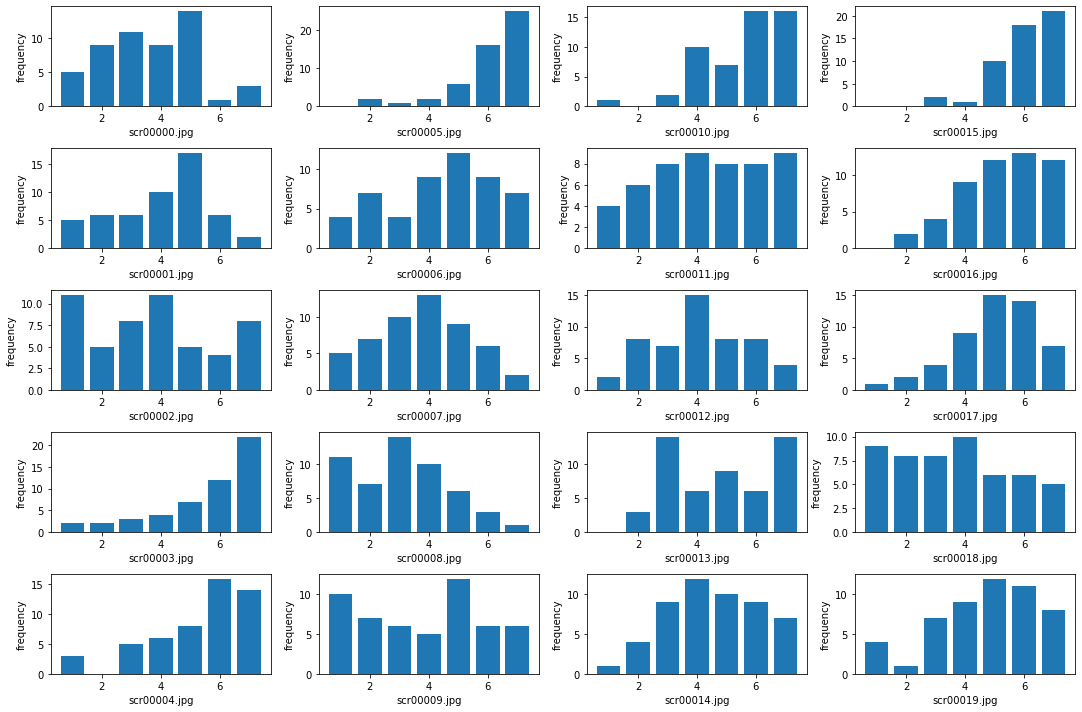

In [16]:
sample_data_likingdfT = sample_data_likingdf.T

fig, axs = plt.subplots(5, 4, figsize= (15,10))

for j,i in enumerate(plist):
    a= np.array((1,2,3,4,5,6,7))
    b= sample_data_likingdfT['%s' % i].values
    axs[j % 5, j // 5].bar(a,b)
    axs[j % 5, j // 5].set_xlabel('%s' % i)
    axs[j % 5, j // 5].set_ylabel('frequency')
    plt.tight_layout()

## Create dataframe of sensory data

In [17]:
pids = 0
subject_data_sensorydf = pd.DataFrame()

for f in flist:
    tmpdfsensory = pd.read_excel('data_files_renumbered_old/%s' % f, sheet_name=2)
    tmpdfcutsensory = tmpdfsensory.loc[tmpdfsensory.index[0:120], ['imageFile', 'question', 'rating.response_raw', 'Unnamed: 5']]
    tmpdfcutsensory['participant'] = pids
    tmpdfcutsensory['participant2'] = pids + len(flist)
    
    subject_data_sensorydf = pd.concat([subject_data_sensorydf,tmpdfcutsensory])
    pids += 1
    
sensorydf1 = subject_data_sensorydf.drop(['Unnamed: 5', 'participant2'], axis=1).rename(columns={"rating.response_raw": "rating"})
sensorydf2 = subject_data_sensorydf.drop(['rating.response_raw', 'participant'], axis=1).rename(columns={"Unnamed: 5": "rating", "participant2": "participant"})
subject_data_sensorydf = pd.concat([sensorydf1, sensorydf2])
subject_data_sensorydf = subject_data_sensorydf.rename(columns={"rating.response_raw": "rating", "imageFile": "planet"})
subject_data_sensorydf

,planet,question,rating,participant
0,images/scr00000.jpg,Water,3.0,0
1,images/scr00000.jpg,Clouds,1.0,0
2,images/scr00000.jpg,Rings,2.0,0
3,images/scr00000.jpg,Moons,3.0,0
4,images/scr00000.jpg,Blue-green,1.0,0
...,...,...,...,...
115,images/scr00019.jpg,Clouds,2.0,57
116,images/scr00019.jpg,Rings,1.0,57
117,images/scr00019.jpg,Moons,1.0,57
118,images/scr00019.jpg,Blue-green,5.0,57


## Similar to before, I excluded subjects who were clearly not engaged in the task. I chose to exclude any subject that provided less that 2 unique ratings on each dimension. I plotted the heatmap for just one dimension (water) below. We can see that most subjects gave a variety of ratings and the planet ratings are fairly consistent across subjects.

In [18]:
alt.Chart(subject_data_sensorydf.query('question == "Water"')).mark_rect().encode(
    x='planet:O',
    y='participant:O',
    color=alt.Color('rating:O', scale=alt.Scale(scheme='yellowgreenblue'))
)



alt.Chart(...)

In [19]:
subject_data_sensorydf = subject_data_sensorydf.groupby(['participant', 'question']).filter(lambda g: len(np.unique(g['rating'])) > 1) 
subject_data_sensorydf = subject_data_sensorydf.groupby('participant').filter(lambda k:  len(np.unique(k['question'])) == 6)
subject_data_sensorydf

,planet,question,rating,participant
0,images/scr00000.jpg,Water,3.0,0
1,images/scr00000.jpg,Clouds,1.0,0
2,images/scr00000.jpg,Rings,2.0,0
3,images/scr00000.jpg,Moons,3.0,0
4,images/scr00000.jpg,Blue-green,1.0,0
...,...,...,...,...
115,images/scr00019.jpg,Clouds,2.0,57
116,images/scr00019.jpg,Rings,1.0,57
117,images/scr00019.jpg,Moons,1.0,57
118,images/scr00019.jpg,Blue-green,5.0,57



## Again, the model is fit to frequency data so we need to aggregate the subject data into a dataframe with the frequency of each rating for each planet

In [20]:
sample_data_sensory = np.zeros((20,6,7))

for k in range(7):
    g = subject_data_sensorydf.drop('participant', axis=1).groupby(['planet', 'question']).agg(lambda x :  len(np.where(x==k+1)[0]))
    for j, i in enumerate(plist):
        sample_data_sensory[j,:,k] = np.squeeze(g.xs('images/%s' % i ,level='planet').values)


## Portions of the parameter estimation functions were written before this notebook. Therefore, I needed to reshape and reorder the sensory and liking matrices so that they could be used as input to the functions

In [21]:
preferenceCountjup = np.zeros((7,20))
for i in range(7):
    for j in range(20):
        preferenceCountjup[i,j] = sample_data_likingdf.values[j,i]
        
sensoryCountjup = np.zeros((7,20,6))

sensoryCountjup[:,:,4] = sample_data_sensory[:,0,:].T
sensoryCountjup[:,:,1] = sample_data_sensory[:,1,:].T
sensoryCountjup[:,:,3] = sample_data_sensory[:,2,:].T
sensoryCountjup[:,:,5] = sample_data_sensory[:,3,:].T
sensoryCountjup[:,:,2] = sample_data_sensory[:,4,:].T
sensoryCountjup[:,:,0] = sample_data_sensory[:,5,:].T
    
              

# Fit model to data

## Create the function to optimize the parameters to fit the sensory data and preference data by minimizing SSE. 

In [22]:
def planetsFunctionOptimizer(x0):
    x0_sensory = x0[0:150]
    x0_pref = x0[150:183]

    [sensoryError, predicted_sensoryCount]  = sensoryFunction(x0_sensory)
    [prefError, predicted_prefCount] = preferenceFunction(x0_pref, x0_sensory)
    
    
    totalError = prefError + sensoryError
    return totalError
    

In [23]:
def sensoryFunction(x0_sensory):
    x0 = x0_sensory
    planets = 20
    dimension = 6
    criterion = 6
    subjects = int(np.sum(sensoryCountjup, axis=0)[0,0])
    area_under0 = np.zeros((planets,dimension))
    area_under01 = np.zeros((planets,dimension))
    area_under12 = np.zeros((planets,dimension))
    area_under23 = np.zeros((planets,dimension))
    area_under34 = np.zeros((planets,dimension))
    area_under45 = np.zeros((planets,dimension))
    area_above5 = np.zeros((planets,dimension))

    mu_sensory = np.concatenate((np.repeat(0,dimension), x0[0:19*dimension])).reshape(planets,dimension)
    criteria = x0[19*dimension:(19*dimension)+(6*dimension)].reshape(dimension,criterion)
    for p in range(planets):
        for d in range(dimension):

            area_under0[p,d] = subjects * sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,0])

            area_under01[p,d] = subjects * (sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,1]) - sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,0]))	

            area_under12[p,d] = subjects * (sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,2]) - sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,1]))	

            area_under23[p,d] = subjects * (sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,3]) - sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,2]))	

            area_under34[p,d] = subjects * (sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,4]) - sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,3]))	

            area_under45[p,d] = subjects * (sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,5]) - sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,4]))

            area_above5[p,d] = subjects * (1 - sp.stats.norm(loc=mu_sensory[p,d], scale=1).cdf(criteria[d,5]))


    predicted_sensoryCount = np.vstack((area_under0, area_under01, area_under12, area_under23, area_under34, area_under45, area_above5)).reshape(7,20,dimension)
    sensoryError = np.sum((predicted_sensoryCount - sensoryCountjup)**2)
    print('sensoryError:')
    print(sensoryError)

    return  sensoryError, predicted_sensoryCount



In [24]:
def preferenceFunction(x0_pref, x0_sensory):
    x0 = x0_pref
    planets = 20
    dimension = 6
    criterion = 6
    subjects = int(np.sum(preferenceCountjup[:,0]))

    z = [-1.282, -0.524, 0, 0.524, 1.282]    
    grid = [p for p in itertools.product(z, repeat=dimension)]


    mu_ideal = x0[21:27]
    ideal_criteria = x0[27:33]

    data = x0[0:21]
#         print(data.shape)
    upper_t = np.zeros((dimension, dimension))
    inds = np.triu_indices(len(upper_t))
    upper_t[inds] = data



    covar_ideal = np.matmul(np.transpose(upper_t), upper_t)

    bin_count = np.zeros((planets,len(ideal_criteria)+1))


    cov_inv = np.linalg.inv(covar_ideal)

    mu_sensory = np.concatenate((np.repeat(0,dimension), x0_sensory[0:114])).reshape(planets,dimension)
    criteria = x0_sensory[114:150].reshape(dimension,criterion)

    mdist = np.zeros((planets, len(grid)))
    for p in range(planets):
        mu_c = mu_ideal - mu_sensory[p,:]
        mean_c = np.tile(mu_c, (len(grid),1))
        mdist[p,:] = np.sum(np.multiply(np.matmul((grid-mean_c),cov_inv), ((grid-mean_c))), axis=1).reshape(len(grid)) 

    mdist_new1= np.copy(mdist)
    mdist_new1[mdist_new1 > ideal_criteria[5]] = 1
    mdist_new1[mdist_new1 != 1] = 0 
    above5 = np.sum(mdist_new1, axis=1)

    mdist_new2= np.copy(mdist)
    mdist_new2[mdist_new2 > ideal_criteria[4]] = 1
    mdist_new2[mdist_new2 != 1] = 0
    above4 = np.sum(mdist_new2, axis=1)

    mdist_new3= np.copy(mdist)
    mdist_new3[mdist_new3 > ideal_criteria[3]] = 1
    mdist_new3[mdist_new3 != 1] = 0 
    above3 = np.sum(mdist_new3, axis=1)

    mdist_new4= np.copy(mdist)
    mdist_new4[mdist_new4 > ideal_criteria[2]] = 1
    mdist_new4[mdist_new4 != 1] = 0 
    above2 = np.sum(mdist_new4, axis=1)

    mdist_new5= np.copy(mdist)
    mdist_new5[mdist_new5 > ideal_criteria[1]] = 1
    mdist_new5[mdist_new5 != 1] = 0 
    above1 = np.sum(mdist_new5, axis=1)

    mdist_new6= np.copy(mdist)
    mdist_new6[mdist_new6 > ideal_criteria[0]] = 1
    mdist_new6[mdist_new6 != 1] = 0 
    above0 = np.sum(mdist_new6, axis=1)

    mdist_new7= np.copy(mdist)
    mdist_new7[mdist_new7 < ideal_criteria[0]] = 1
    mdist_new7[mdist_new7 != 1] = 0 
    below0 = np.sum(mdist_new7, axis=1)


    bin_count1 = above5
    bin_count2 = np.subtract(above4, above5)
    bin_count3 = np.subtract(above3, above4)
    bin_count4 = np.subtract(above2, above3)

    bin_count5 = np.subtract(above1, above2)
    bin_count6 = np.subtract(above0, above1)
    bin_count7 = below0

    bin_count = np.vstack((bin_count1, bin_count2, bin_count3, bin_count4, bin_count5, bin_count6, bin_count7))

    predicted_prefCount = (bin_count/len(grid)*subjects)

    prefError = np.sum((predicted_prefCount - preferenceCountjup)**2)
    print('prefError:')
    print(prefError)

    return prefError, predicted_prefCount

## define constraints on parameters (ordering of criteria, positive semi-definite covariance matrix) 

In [25]:
# contraints on sensory criteria

def con11(x):
    return x0[115] - x0[114]
def con12(x):
    return x0[116] - x0[115]
def con13(x):
    return x0[117] - x0[116]
def con14(x):
    return x0[118] - x0[117]
def con15(x):
    return x0[119] - x0[118]

def con21(x):
    return x0[121] - x0[120]
def con22(x):
    return x0[122] - x0[121]
def con23(x):
    return x0[123] - x0[122]
def con24(x):
    return x0[124] - x0[123]
def con25(x):
    return x0[125] - x0[124]

def con31(x):
    return x0[127] - x0[126]
def con32(x):
    return x0[128] - x0[127]
def con33(x):
    return x0[129] - x0[128]
def con34(x):
    return x0[130] - x0[129]
def con35(x):
    return x0[131] - x0[130]

def con41(x):
    return x0[133] - x0[132]
def con42(x):
    return x0[134] - x0[133]
def con43(x):
    return x0[135] - x0[134]
def con44(x):
    return x0[136] - x0[135]
def con45(x):
    return x0[137] - x0[136]

def con51(x):
    return x0[139] - x0[138]
def con52(x):
    return x0[140] - x0[139]
def con53(x):
    return x0[141] - x0[140]
def con54(x):
    return x0[142] - x0[141]
def con55(x):
    return x0[143] - x0[142]

def con61(x):
    return x0[145] - x0[144]
def con62(x):
    return x0[146] - x0[145]
def con63(x):
    return x0[147] - x0[146]
def con64(x):
    return x0[148] - x0[147]
def con65(x):
    return x0[149] - x0[148]





# contraints on ideal criteria
def con71(x):
    return x0[150+28] - x0[150+27]
def con72(x): 
    return x0[150+29] - x0[150+28]
def con73(x):
    return x0[150+30] - x0[150+29]
def con74(x):
    return x0[150+31] - x0[150+30]
def con75(x):
    return x0[150+32] - x0[150+31]

# constraints on diagonal of Ideal covariance matrix

def con81(x):

    data = x0[150:150+int(dimension*(dimension+1)/2)]
    upper_t = np.zeros((dimension, dimension))
    inds = np.triu_indices(len(upper_t))
    upper_t[inds] = data
    
    covar_ideal = np.matmul(np.transpose(upper_t), upper_t)
    
    return covar_ideal[0,0]

def con82(x):
    
    data = x0[150:150+int(dimension*(dimension+1)/2)]
    upper_t = np.zeros((dimension, dimension))
    inds = np.triu_indices(len(upper_t))
    upper_t[inds] = data

    covar_ideal = np.matmul(np.transpose(upper_t), upper_t)
    
    return covar_ideal[1,1]

def con83(x):
    data = x0[150:150+int(dimension*(dimension+1)/2)]
    upper_t = np.zeros((dimension, dimension))
    inds = np.triu_indices(len(upper_t))
    upper_t[inds] = data
    
    
    covar_ideal = np.matmul(np.transpose(upper_t), upper_t)
    
    return covar_ideal[2,2]

def con84(x):
    data = x0[150:150+int(dimension*(dimension+1)/2)]
    upper_t = np.zeros((dimension, dimension))
    inds = np.triu_indices(len(upper_t))
    upper_t[inds] = data
    
    
    covar_ideal = np.matmul(np.transpose(upper_t), upper_t)
    
    return covar_ideal[3,3]

def con85(x):
    data = x0[150:150+int(dimension*(dimension+1)/2)]
    upper_t = np.zeros((dimension, dimension))
    inds = np.triu_indices(len(upper_t))
    upper_t[inds] = data
    
    
    covar_ideal = np.matmul(np.transpose(upper_t), upper_t)
    
    return covar_ideal[4,4]

def con86(x):
    data = x0[150:150+int(dimension*(dimension+1)/2)]
    upper_t = np.zeros((dimension, dimension))
    inds = np.triu_indices(len(upper_t))
    upper_t[inds] = data
    
    
    covar_ideal = np.matmul(np.transpose(upper_t), upper_t)
    
    return covar_ideal[5,5]

# constrain Ideal covariance matrix to be invertable

cons = [{'type':'ineq', 'fun': con11},
        {'type':'ineq', 'fun': con12},
        {'type':'ineq', 'fun': con13},
        {'type':'ineq', 'fun': con14},
        {'type':'ineq', 'fun': con15},
        {'type':'ineq', 'fun': con21},
        {'type':'ineq', 'fun': con22},
        {'type':'ineq', 'fun': con23},
        {'type':'ineq', 'fun': con24},
        {'type':'ineq', 'fun': con25},
        {'type':'ineq', 'fun': con31},
        {'type':'ineq', 'fun': con32},
        {'type':'ineq', 'fun': con33},
        {'type':'ineq', 'fun': con34},
        {'type':'ineq', 'fun': con35},
        {'type':'ineq', 'fun': con41},
        {'type':'ineq', 'fun': con42},
        {'type':'ineq', 'fun': con43},
        {'type':'ineq', 'fun': con44},
        {'type':'ineq', 'fun': con45},
        {'type':'ineq', 'fun': con51},
        {'type':'ineq', 'fun': con52},
        {'type':'ineq', 'fun': con53},
        {'type':'ineq', 'fun': con54},
        {'type':'ineq', 'fun': con55},
        {'type':'ineq', 'fun': con61},
        {'type':'ineq', 'fun': con62},
        {'type':'ineq', 'fun': con63},
        {'type':'ineq', 'fun': con64},
        {'type':'ineq', 'fun': con65},
        {'type':'ineq', 'fun': con71},
        {'type':'ineq', 'fun': con72},
        {'type':'ineq', 'fun': con73},
        {'type':'ineq', 'fun': con74},
        {'type':'ineq', 'fun': con75},
        {'type':'ineq', 'fun': con81},
        {'type':'ineq', 'fun': con82},
        {'type':'ineq', 'fun': con83},
        {'type':'ineq', 'fun': con84},
        {'type':'ineq', 'fun': con85},
        {'type':'ineq', 'fun': con86}]



## set random initial conditions for parameter vector (x0). Only uncomment and run if you intend to run the optimization function. 

In [26]:
# dimension = 6
# x0 = np.zeros(183)

# # 6 means * 19 planets (one is set to zeros)
# x0[0:114] = np.random.normal(size=114)

# # 6 criteria * 6 dimensions
# x0[114:120] = (np.random.uniform(-1,-0.7,size=1),np.random.uniform(-0.7,-0.4,size=1),np.random.uniform(-0.4,0,size=1),np.random.uniform(0,0.4,size=1),np.random.uniform(0.4,0.7,size=1),np.random.uniform(0.7,1,size=1)) #np.arange(-1,1.1,.4)
# x0[120:126] = (np.random.uniform(-1,-0.7,size=1),np.random.uniform(-0.7,-0.4,size=1),np.random.uniform(-0.4,0,size=1),np.random.uniform(0,0.4,size=1),np.random.uniform(0.4,0.7,size=1),np.random.uniform(0.7,1,size=1))#np.arange(-1,1.1,.4)
# x0[126:132] = (np.random.uniform(-1,-0.7,size=1),np.random.uniform(-0.7,-0.4,size=1),np.random.uniform(-0.4,0,size=1),np.random.uniform(0,0.4,size=1),np.random.uniform(0.4,0.7,size=1),np.random.uniform(0.7,1,size=1))#np.arange(-1,1.1,.4)
# x0[132:138] = (np.random.uniform(-1,-0.7,size=1),np.random.uniform(-0.7,-0.4,size=1),np.random.uniform(-0.4,0,size=1),np.random.uniform(0,0.4,size=1),np.random.uniform(0.4,0.7,size=1),np.random.uniform(0.7,1,size=1))#np.arange(-1,1.1,.4)
# x0[138:144] = (np.random.uniform(-1,-0.7,size=1),np.random.uniform(-0.7,-0.4,size=1),np.random.uniform(-0.4,0,size=1),np.random.uniform(0,0.4,size=1),np.random.uniform(0.4,0.7,size=1),np.random.uniform(0.7,1,size=1))#np.arange(-1,1.1,.4)
# x0[144:150] = (np.random.uniform(-1,-0.7,size=1),np.random.uniform(-0.7,-0.4,size=1),np.random.uniform(-0.4,0,size=1),np.random.uniform(0,0.4,size=1),np.random.uniform(0.4,0.7,size=1),np.random.uniform(0.7,1,size=1))#np.arange(-1,1.1,.4)


# x0[150:171] = np.random.normal(size=int(dimension*(dimension+1)/2))
# x0[171:177] = np.random.normal(size=dimension)
# x0[177:183] = (np.random.uniform(-1,-0.7,size=1),np.random.uniform(-0.7,-0.4,size=1),np.random.uniform(-0.4,0,size=1),np.random.uniform(0,0.4,size=1),np.random.uniform(0.4,0.7,size=1),np.random.uniform(0.7,1,size=1))


## Uncomment to run the optimization but this takes a long time so the optimal values that were found are hardcoded below

In [27]:
# res_numerical_total = sp.optimize.minimize(planetsFunctionOptimizer, x0, method='COBYLA', constraints=cons, tol=0.0001, options={'maxiter': 10000, 'disp': True})

## Parameter vector

In [28]:
x0 = np.array((6.693026E-01,   2.999721E-02,   1.990198E+00,   3.051399E-01,   1.354761E+00,
      -9.585471E-01,  -1.053539E+00,  -1.035360E+00,  -6.057828E-01,   9.866908E-01,
      -1.443276E+00,  -3.467193E-02,   2.226383E+00,   1.838705E+00,  -6.267763E-01,
      -1.454954E+00,   9.457097E-01,  -1.381249E+00,   2.082319E+00,   7.757446E-01,
      -8.591760E-01,  -5.116956E-01,   1.210075E+00,  -1.367163E+00,   1.749777E+00,
       1.692367E+00,   2.614927E+00,   9.736163E-01,   8.090763E-01,  -7.782124E-01,
      -9.189720E-01,   5.262878E-01,  -5.981329E-01,  -9.909064E-01,  -1.341591E+00,
       2.738226E+00,  -9.637206E-01,  -4.257205E-01,   2.200309E+00,  -1.152291E+00,
      -7.791615E-01,  -2.475409E-01,  -9.131029E-01,  -6.388471E-01,  -6.756985E-01,
      -1.251745E+00,  -1.211540E+00,   1.855265E-01,  -9.453948E-01,  -1.125291E+00,
      -9.271957E-01,   7.129547E-01,  -1.243110E+00,   8.965008E-01,   1.563199E+00,
       6.893354E-01,   1.318542E+00,  -1.119230E+00,   8.986572E-01,  -9.231663E-01,
      -4.177392E-01,   6.929274E-02,  -5.163451E-01,   8.384187E-01,  -2.820308E-01,
      -1.882306E-01,   2.809868E-01,  -2.477262E-02,   2.420594E+00,  -7.333103E-01,
       4.580353E-01,  -6.324816E-01,  -2.652188E-01,   3.863840E-02,   2.157422E+00,
       5.058486E-01,  -2.349021E-01,   5.055360E-01,   1.771222E-01,   1.390693E-02,
       1.672696E+00,   4.505002E-01,   3.917603E-01,  -5.544972E-01,   1.947890E+00,
       1.514699E+00,   2.371144E+00,  -1.220222E+00,   1.485276E+00,  -4.710490E-01,
       8.779599E-01,  -3.191267E-01,   2.644160E+00,  -1.266330E+00,   2.669212E-01,
       1.491052E+00,   5.917383E-01,  -2.895759E-01,   1.206982E+00,  -9.767512E-01,
       2.525727E-01,   4.480840E-01,  -1.096025E+00,  -9.132559E-01,  -6.813591E-01,
       1.052438E+00,  -1.472300E+00,   3.979670E-01,   3.505925E-01,  -1.214071E-01,
      -5.904865E-01,  -1.282206E+00,   9.201194E-01,   1.327166E+00,  -4.357364E-01,
      -4.315054E-01,   1.634453E-01,   4.828586E-01,   9.413772E-01,   1.466137E+00,
       1.969809E+00,  -8.030444E-01,  -2.161792E-01,   1.517311E-01,   5.124718E-01,
       9.870089E-01,   1.812305E+00,   2.311210E-01,   3.913419E-01,   6.671593E-01,
       1.011253E+00,   1.394841E+00,  1.868694E+00,  -5.432503E-01,   4.932025E-02,
       4.062804E-01,  8.091968E-01,   1.091694E+00,   1.518143E+00,  -4.545095E-01,
       1.296064E-01,   4.848115E-01,   9.169520E-01,   1.346237E+00,   1.776911E+00,
      -2.650036E-01,   3.701029E-01,   8.545417E-01,   1.271702E+00,   1.755478E+00,
       2.280978E+00,   2.911084E+00,   1.054091E+00,  -4.598585E-01,   1.041802E+00,
       1.834670E+00,  -1.347702E+00,  -2.897631E+00,  1.939406E-01,   9.513362E-01,
       6.874190E-01,   2.260925E+00,   4.148589E+00,   4.796423E-01,   2.462280E-01,
      -1.988898E-01,  -3.975396E+00,   1.890044E+00,   1.917043E+00,  -2.934838E+00,
       7.938894E-01,   3.153750E+00,   2.373747E+00,   2.041710E+00,   1.644244E+00,
       6.234208E-01,  -5.714365E-02,  -1.501401E-01,   2.588446E-01,   9.736656E-01,
       1.477312E+00,   1.978594E+00,   2.589752E+00,   3.215266E+00,   3.871750E+00))

## separate sensory and liking parameters

In [29]:
x0_sensory = np.concatenate((x0[0:114],x0[115:151]))
x0_pref = np.concatenate((x0[151:172], x0[173:185]))

# Results

## SSE and $R^2$ for sensory parameter fits to data

In [30]:
sse_sensory, predicted_sensoryCount = sensoryFunction(x0_sensory)

sensoryError:
4555.416909528731


In [31]:
sp.stats.pearsonr(predicted_sensoryCount.flatten(), sensoryCountjup.flatten())[0]**2

0.9468074198810272

## SSE and $R^2$ for fit to preference data

In [32]:
sse_pref, predicted_prefCount = preferenceFunction(x0_pref, x0_sensory)

prefError:
1041.75262928896


In [33]:
sp.stats.pearsonr(predicted_prefCount.flatten(), preferenceCountjup.flatten())[0]**2

0.6880244625239194

## Analysis of the ideal covariance matrix suggests that Water and Clouds have low variance which indicate that they are important factors in determining subjects preference judgements. Future work will consider removing some of the less important dimensions and comparing model performance

In [34]:
dimension=6
data = x0_pref[0:21]
upper_t = np.zeros((dimension, dimension))
inds = np.triu_indices(len(upper_t))
upper_t[inds] = data


covar_ideal = np.matmul(np.transpose(upper_t), upper_t)
planetResultsCovariance = pd.DataFrame(covar_ideal, columns=['Water','Clouds','Rings','Moons','Blue-green','Red-yellow'],index=['Water','Clouds','Rings','Moons','Blue-green','Red-yellow'])
planetResultsCovariance

,Water,Clouds,Rings,Moons,Blue-green,Red-yellow
Water,8.474410,3.068547,-1.338687,3.032773,5.340878,-3.923274
Clouds,3.068547,9.507373,-1.046701,-1.658467,-0.057977,-7.971927
Rings,-1.338687,-1.046701,17.459873,1.695260,0.311129,0.233125
Moons,3.032773,-1.658467,1.695260,18.024222,-4.830243,-6.969540
Blue-green,5.340878,-0.057977,0.311129,-4.830243,16.084728,0.326001
Red-yellow,-3.923274,-7.971927,0.233125,-6.969540,0.326001,21.219093


## We can also plot the position of the planets sensory distributions on each dimension along with the sensory criteria to get an idea of the representation of the factors in the chosen planet set.

## sort the planets on each dimension

In [35]:
planets_by_dim = np.concatenate((np.repeat(0,dimension), x0_sensory[0:19*dimension])).reshape(20,dimension)
planetsort = np.argsort(planets_by_dim,axis=0)


## get sensory criteria

In [36]:
sensorycriteria = x0[114:150].reshape(6,6)

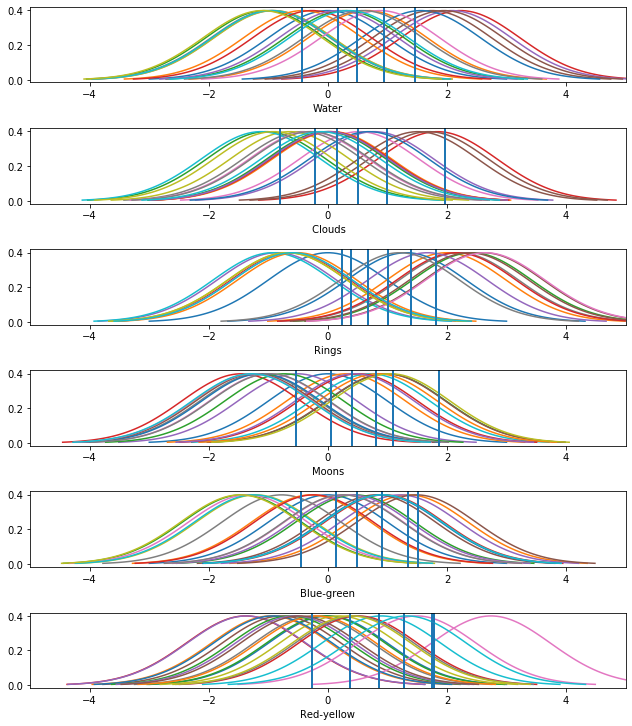

In [37]:
fig, ax = plt.subplots(6, 1, figsize=(9, 10))
dimensions = ['Water',' Clouds', 'Rings', 'Moons','Blue-green', 'Red-yellow']

for dim in range(6):
    plt.tight_layout()
    for j in range(20):
        mu = planets_by_dim[j,dim]
        variance = 1
        sigma = math.sqrt(variance)
        x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        ax[dim].plot(x, stats.norm.pdf(x, mu, sigma))
        ax[dim].set_xlim([-5,5])
        ax[dim].set_xlabel(dimensions[dim])
        for i in range(6):
            ax[dim].axvline(x=sensorycriteria[dim,i])
        

## Since the model suggests that water and clouds are important dimensions we can make a 2d scatter plot of the planets on each dimension. Additionally, because the model returns a mean on each dimension we can plot this as well and look at its location relative to the other planets. The yellow start represents the location of the ideal. You can hover over the points representing each planet to see an image of the planet.

## get the ideal means and criteria

In [38]:
mu_ideal_plot = x0_pref[21:27]
mu_ideal_plot

array([ 2.04171   ,  1.644244  ,  0.6234208 , -0.05714365, -0.1501401 ,
        0.2588446 ])

In [39]:
ideal_crit = x0_pref[27:33]
ideal_crit

array([0.9736656, 1.477312 , 1.978594 , 2.589752 , 3.215266 , 3.87175  ])

## The following function to design this plot was modfied from code found on stackxchange https://stackoverflow.com/questions/20399243/display-message-when-hovering-over-something-with-mouse-cursor-in-python

In [40]:
%matplotlib notebook


def planethoverScatter(x,y,img_array, title, idealx=None, idealy=None, d_name = [None,None]):
    # create figure and plot scatter
    fig = plt.figure(figsize= (10,10))
    plt.title(title, fontsize=16)
    ax = fig.add_subplot(111)
    line, = ax.plot(x,y, ls="", marker="o", c='k')
    if d_name: 
        ax.set_xlabel(d_name[0])
        ax.set_ylabel(d_name[1])
    # create the annotations box
    im = OffsetImage(PIL.Image.fromarray(img_array[0]), zoom=0.1)
    xybox=(50., 50.)
    ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
            boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
    # add it to the axes and make it invisible
    ax.add_artist(ab)
    ab.set_visible(False)
    
    if idealx:
        plt.scatter(idealx, idealy, marker='*', s=500, c='y')

    def hover(event):
        # if the mouse is over the scatter points
        if line.contains(event)[0]:
            # find out the index within the array from the event
            ind, = line.contains(event)[1]["ind"]
            # get the figure size
            w,h = fig.get_size_inches()*fig.dpi
            ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
            hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
            # if event occurs in the top or right quadrant of the figure,
            # change the annotation box position relative to mouse.
            ab.xybox = (xybox[0]*ws, xybox[1]*hs)
            # make annotation box visible
            ab.set_visible(True)
            # place it at the position of the hovered scatter point
            ab.xy =(x[ind], y[ind])
            # set the image corresponding to that point
            im.set_data(PIL.Image.fromarray(img_array[ind]))#arr[ind,:,:])
        else:
            #if the mouse is not over a scatter point
            ab.set_visible(False)
        fig.canvas.draw_idle()

    # add callback for mouse moves
    fig.canvas.mpl_connect('motion_notify_event', hover)           
    plt.show()

<IPython.core.display.Javascript object>


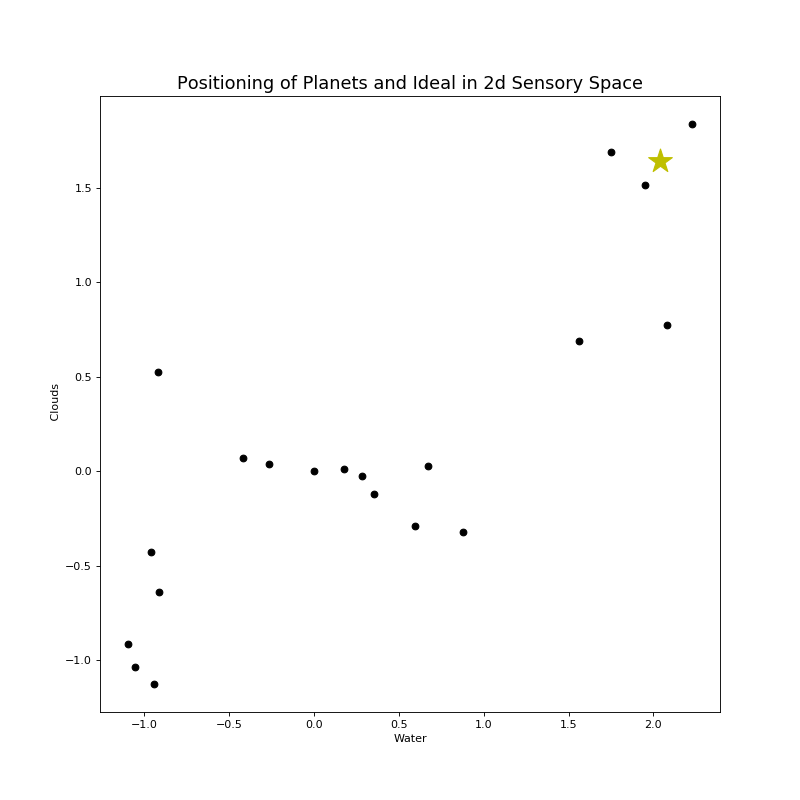

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


In [41]:
d = [0,1]
d_name = ['Water',' Clouds', 'Rings', 'Moons','Blue-green', 'Red-yellow']
dim_name= [d_name[i] for i in d]
x = planets_by_dim[:,d[0]] 
y = planets_by_dim[:,d[1]] 



img_array = [] 
for j, i in enumerate(plist):
    path="planets/%s" % i
    planet_image = Image.open(path)
    planet_image = planet_image.resize((1536,864),Image.ANTIALIAS)

    img_array.append(np.array(planet_image))

title = "Positioning of Planets and Ideal in 2d Sensory Space"
planethoverScatter(x,y,img_array, title, idealx = mu_ideal_plot[d[0]], idealy = mu_ideal_plot[d[1]], d_name=dim_name)

In [42]:
def planethoverScatter1d(x,y,img_array, fig=None, ax=None, idealx = None, idealy = None, dim=None):
    # create figure and plot scatter
    if ax is None:
        fig, ax = plt.subplots(1,1)
    dimension = ['Water',' Clouds', 'Rings', 'Moons','Blue-green', 'Red-yellow']
    ax.set_yticklabels([])
    ax.get_yaxis().set_ticks([])
    line, = ax.plot(x,y, ls="", marker="o", c='k')
    ax.set_xlabel(dimensions[dim])
    # create the annotations box
    im = OffsetImage(PIL.Image.fromarray(img_array[0]), zoom=0.1)
    xybox=(0., 75.)
    ab = AnnotationBbox(im, (0,0), xybox=xybox, xycoords='data',
            boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
    # add it to the axes and make it invisible
    ax.add_artist(ab)
    ab.set_visible(False)
    
    if idealx:
        ax.scatter(idealx, idealy, marker='*', s=150, c='y')

    def hover(event):
        # if the mouse is over the scatter points
        if line.contains(event)[0]:
            # find out the index within the array from the event
            ind, = line.contains(event)[1]["ind"]
            # get the figure size
            w,h = fig.get_size_inches()*fig.dpi
            ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
            hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
            # if event occurs in the top or right quadrant of the figure,
            # change the annotation box position relative to mouse.
#             ab.xybox = (xybox[0]*ws, xybox[1]*hs)
            # make annotation box visible
            ab.set_visible(True)
            # place it at the position of the hovered scatter point
            ab.xy =(x[ind], y[ind])
            # set the image corresponding to that point
            im.set_data(PIL.Image.fromarray(img_array[ind]))#arr[ind,:,:])
        else:
            #if the mouse is not over a scatter point
            ab.set_visible(False)
        fig.canvas.draw_idle()

    # add callback for mouse moves
    fig.canvas.mpl_connect('motion_notify_event', hover)           
    plt.show()

<IPython.core.display.Javascript object>


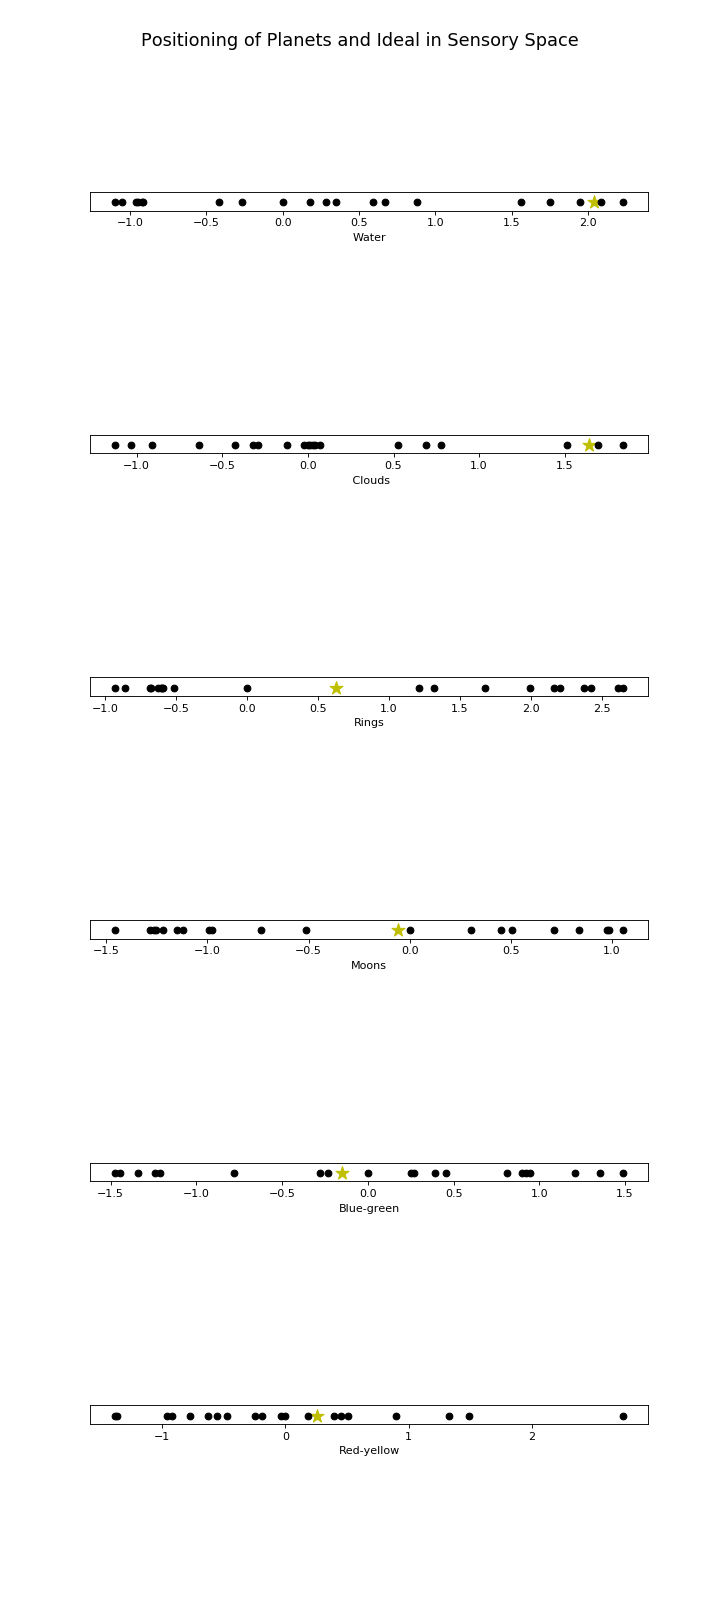

In [43]:
fig, axs = plt.subplots(6, 1, figsize= (9,20))
plt.subplots_adjust(hspace = 12)
fig.suptitle("Positioning of Planets and Ideal in Sensory Space", fontsize=16)
    
for o in range(6):
    x = planets_by_dim[:,o] 
    y = np.zeros(np.shape(planets_by_dim[:,o]))
    img_array = []
    
    for j, i in enumerate(plist):
        path="planets/%s" % i
        planet_image = Image.open(path)
        planet_image = planet_image.resize((1536,864),Image.ANTIALIAS)


        img_array.append(np.array(planet_image))


#     axs[o].planethoverScatter1d(x,y,img_array, mu_ideal_plot[o], 0, o)
    planethoverScatter1d(x,y,img_array, fig=fig, ax = axs[o], idealx = mu_ideal_plot[o], idealy = 0, dim=o)

# Apply nonnegative matrix factorization to subject liking data.

There are a couple reasons I wanted to do this. First, seems NMF could be suitably applied to this dataset in such a way that if there were missing data, NMF should be able to recommend planets to subjects. Of course, this dataset is tiny, but in theory lots of data could be collected online in a manner that would result in empty cells. In the current application it's unclear why we would want to recommend a planet to an individual subject (what were really after is the ideal planet for the space probe). However, the ideal model could be applied to any situation in which sensory and liking judgements are collected; therefore, my model could find the popuation ideal and be complemented by NMF to make individual recommendations.

Second, I'd like to see if there is some agreement between NMF latent factors for individual subject data and locations of planets and their distance to the ideal generated by model.

In the interest of exploring avenues that don't constrain the matrices I also applied PCA following NMF.

In [44]:
## Non-negative Matrix Factorization
def non_negative_marix_decomp(n_components, array_data):
    import sklearn.decomposition as skld
    model = skld.NMF(n_components=n_components, init='nndsvda', max_iter=500, random_state=0)
    W = model.fit_transform(array_data)
    
    # Normalize basis vectors to sum to 1
    Wsum = W.sum(axis=0)
    W = W/Wsum
    
    ## fix H correspondingly
    H = model.components_
    H = (H.T * Wsum).T

    nmf = (W, H)
    return(nmf)

In [45]:
subject_liking_matrix = subject_data_liking.values

In [46]:
W, H = non_negative_marix_decomp(2,subject_liking_matrix)


In [47]:
reconstructedNMF = W@H

In [48]:
sp.stats.pearsonr(reconstructedNMF.flatten(), subject_data_liking.values.flatten())[0]**2

0.4953312205193055

In [49]:
ps_data1 = np.argsort(W[:,0])
ps_data2 = np.argsort(W[:,1])
ps_data = np.vstack((ps_data1,ps_data2))

<IPython.core.display.Javascript object>


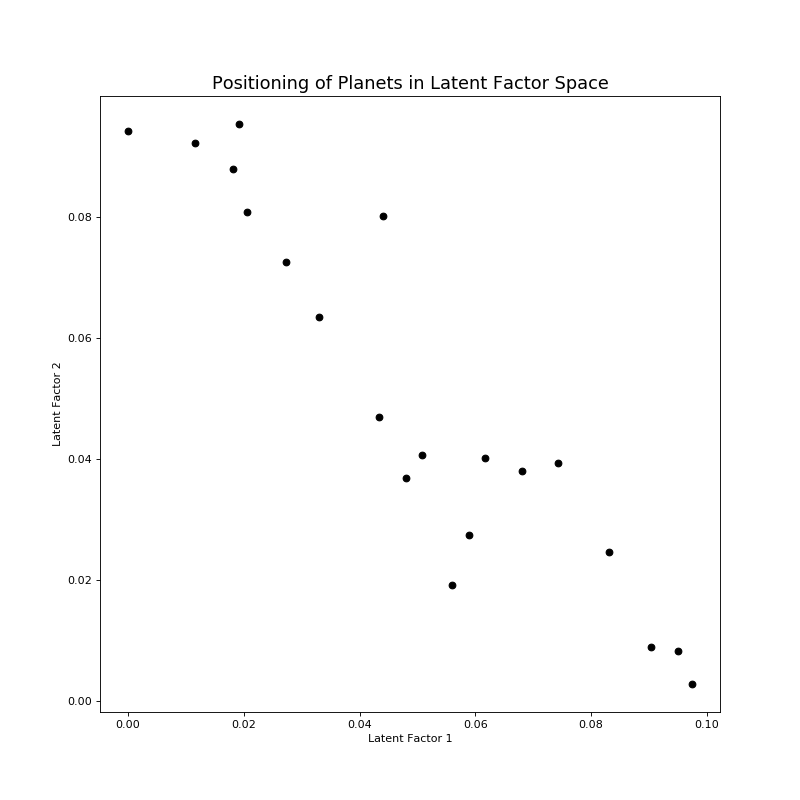

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


In [50]:
d_name = ['Latent Factor 1', 'Latent Factor 2']
d = []
x = W[:,0]
y = W[:,1]
img_array
planethoverScatter(x,y,img_array, title='Positioning of Planets in Latent Factor Space', d_name=d_name)

## It seems that latent factor 1 and 2 are almost perfectly negatively correlated as shown by pearson's r below. At first, I thought this may be a result of the forced nonegativity. Nonetheless, I thought it would be interesting to see if the latent factors discovered by NMF may be either linear combinations of sensory dimension ratings or linear combinations of vectors representing the distance of planets from the ideal on each dimension.

In [51]:
sp.stats.pearsonr(W[:,1], W[:,0])

(-0.9319553469153025, 2.3161508368313835e-09)

## NMF latent factors are linear combinations of sensory positions of planets from ideal model

In [52]:
def lm(X,y):
    
    lm = LinearRegression()
    reg = lm.fit(X, y)

#     print(reg.score(X, y))
    ar2 = 1 - ((1- reg.score(X, y))*(len(X[:,0])-1)/(len(X[:,0])-len(X[0,:])-1)) 
    print('adjusted R^2 = %f' % ar2)    
    print('p =%i' % len(X[0,:]))
    print('r =%i' % len(X[:,0]))

    params = np.append(lm.intercept_,lm.coef_)
    predictions = lm.predict(X)

    newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["Probabilities"] = [params,sd_b,ts_b,p_values]
#     print(myDF3)
    


### Latent Factor 1

In [53]:
lm(planets_by_dim,W[:,0])

adjusted R^2 = 0.934396
p =6
r =20


In [54]:
for i in range(6):
    planetsdim = np.delete(planets_by_dim, i, axis=1)
    lm(planetsdim,W[:, 0])

adjusted R^2 = 0.856894
p =5
r =20
adjusted R^2 = 0.928701
p =5
r =20
adjusted R^2 = 0.938486
p =5
r =20
adjusted R^2 = 0.653790
p =5
r =20
adjusted R^2 = 0.939072
p =5
r =20
adjusted R^2 = 0.938762
p =5
r =20


In [55]:
for i in range(5):
    planetsdim = np.delete(planets_by_dim[:,(0,1,2,3,5)], i, axis=1)
    lm(planetsdim,W[:, 0])

adjusted R^2 = 0.777782
p =4
r =20
adjusted R^2 = 0.933190
p =4
r =20
adjusted R^2 = 0.942546
p =4
r =20
adjusted R^2 = 0.676006
p =4
r =20
adjusted R^2 = 0.942844
p =4
r =20


In [56]:
for i in range(4):
    planetsdim = np.delete(planets_by_dim[:,(0,1,2,3)], i, axis=1)
    lm(planetsdim,W[:, 0])

adjusted R^2 = 0.737404
p =3
r =20
adjusted R^2 = 0.936748
p =3
r =20
adjusted R^2 = 0.945846
p =3
r =20
adjusted R^2 = 0.658415
p =3
r =20


In [57]:
for i in range(3):
    planetsdim = np.delete(planets_by_dim[:,(0,1,3)], i, axis=1)
    lm(planetsdim,W[:, 0])

adjusted R^2 = 0.740265
p =2
r =20
adjusted R^2 = 0.939863
p =2
r =20
adjusted R^2 = 0.678194
p =2
r =20


In [58]:
for i in range(2):
    planetsdim = np.delete(planets_by_dim[:,(0,3)], i, axis=1)
    lm(planetsdim,W[:, 0])

adjusted R^2 = 0.548665
p =1
r =20
adjusted R^2 = 0.687511
p =1
r =20


### Latent factor 2

In [59]:
lm(planets_by_dim,W[:,1])

adjusted R^2 = 0.946435
p =6
r =20


In [60]:
for i in range(6):
    planetsdim = np.delete(planets_by_dim, i, axis=1)
    lm(planetsdim,W[:, 1])

adjusted R^2 = 0.805696
p =5
r =20
adjusted R^2 = 0.950135
p =5
r =20
adjusted R^2 = 0.936244
p =5
r =20
adjusted R^2 = 0.896540
p =5
r =20
adjusted R^2 = 0.945892
p =5
r =20
adjusted R^2 = 0.925474
p =5
r =20


In [61]:
for i in range(5):
    planetsdim = np.delete(planets_by_dim[:,(0,2,3,4,5)], i, axis=1)
    lm(planetsdim,W[:, 1])

adjusted R^2 = 0.720562
p =4
r =20
adjusted R^2 = 0.940174
p =4
r =20
adjusted R^2 = 0.903396
p =4
r =20
adjusted R^2 = 0.948942
p =4
r =20
adjusted R^2 = 0.930045
p =4
r =20


In [62]:
for i in range(4):
    planetsdim = np.delete(planets_by_dim[:,(0,2,3,5)], i, axis=1)
    lm(planetsdim,W[:, 1])

adjusted R^2 = 0.454518
p =3
r =20
adjusted R^2 = 0.943293
p =3
r =20
adjusted R^2 = 0.906884
p =3
r =20
adjusted R^2 = 0.926977
p =3
r =20


In [63]:
for i in range(3):
    planetsdim = np.delete(planets_by_dim[:,(0,3,5)], i, axis=1)
    lm(planetsdim,W[:, 1])

adjusted R^2 = 0.423563
p =2
r =20
adjusted R^2 = 0.904049
p =2
r =20
adjusted R^2 = 0.923613
p =2
r =20


In [64]:
for i in range(2):
    planetsdim = np.delete(planets_by_dim[:,(0,3)], i, axis=1)
    lm(planetsdim,W[:, 1])

adjusted R^2 = 0.301824
p =1
r =20
adjusted R^2 = 0.849372
p =1
r =20


In [65]:
lm(planets_by_dim[:,0:1],W[:, 1])

adjusted R^2 = 0.849372
p =1
r =20


The latent factors appear to be linear combinations of sensory dimension 1 (water) and 4 (moons). Latent factor two also appears to be correlated with sensory dimension 6 (red-yellow). 

Focusing on just water and moons, these results seem to fit if we hover over the 2d scatterplot for the latent factors. On latent factor 1, most of the planets with moons are concentrated at the higher values. Similarly, on latent factor 2, most of the watery planets are concentrated at higher values. This pattern matches the sign of the regression coefficients.

## in our previous analysis of the ideal model we plotted the 2d space with water and clouds as those were the ones the model deemed most important. However, given that the latent factors from NMF suggest that they are primarily linear combinations of water and moons, we will plot these dimensions as well.

<IPython.core.display.Javascript object>


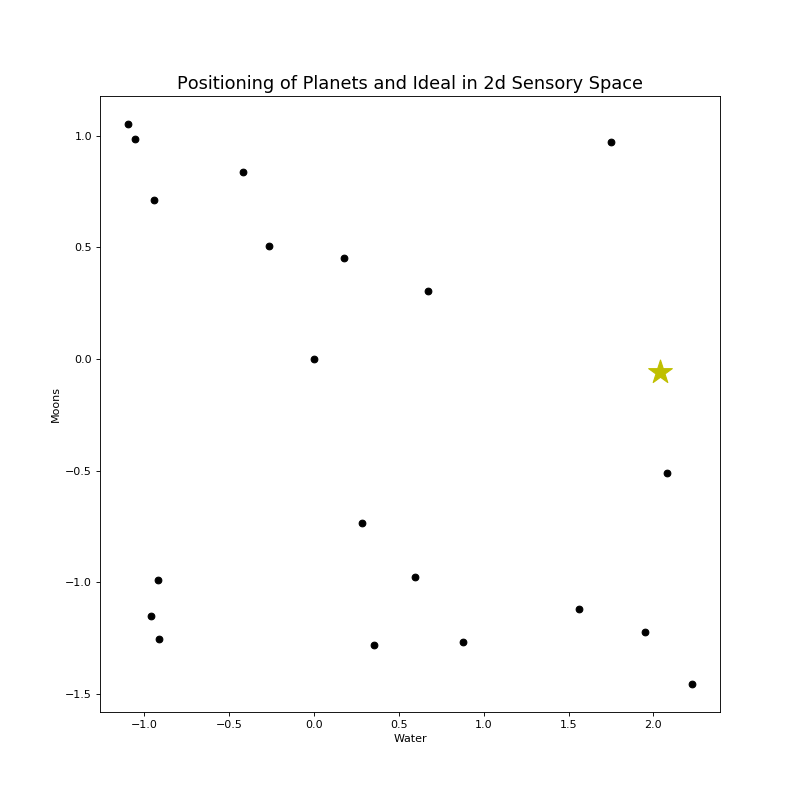

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


In [66]:
d = [0,3]
d_name = ['Water',' Clouds', 'Rings', 'Moons','Blue-green', 'Red-yellow']
dim_name= [d_name[i] for i in d]
x = planets_by_dim[:,d[0]] 
y = planets_by_dim[:,d[1]] 



img_array = [] 
for j, i in enumerate(plist):
    path="planets/%s" % i
    planet_image = Image.open(path)
    planet_image = planet_image.resize((1536,864),Image.ANTIALIAS)

    img_array.append(np.array(planet_image))

title = "Positioning of Planets and Ideal in 2d Sensory Space"
planethoverScatter(x,y,img_array, title, idealx = mu_ideal_plot[d[0]], idealy = mu_ideal_plot[d[1]], d_name=dim_name)

It seems that the ideal has high levels of water and a moderate prominence of moons according to this figure. Addtionally, we can hover over the planets to see that there is fairly strong agreement between the ideal model and the NMF with respect to their relative placement on the extremes (bottom right and top left) but the ideal model appears deviate from the latent factors in the middle of the range of values.

# Apply PCA to subject liking data.


In [67]:
subject_liking_matrix = subject_data_liking.values

In [68]:
from sklearn.decomposition import PCA

pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(subject_liking_matrix)
print(subject_liking_matrix.shape)
print(projected.shape)
pca.explained_variance_ratio_

(20, 52)
(20, 2)


array([0.37689067, 0.13723387])

In [69]:
X_pca = pca.transform(subject_liking_matrix)
reconstructedPCA = pca.inverse_transform(X_pca)

reconstructedPCA.shape

(20, 52)

In [70]:
sp.stats.pearsonr(reconstructedPCA.flatten(), subject_liking_matrix.flatten())[0]**2

0.5782677255387794

<IPython.core.display.Javascript object>


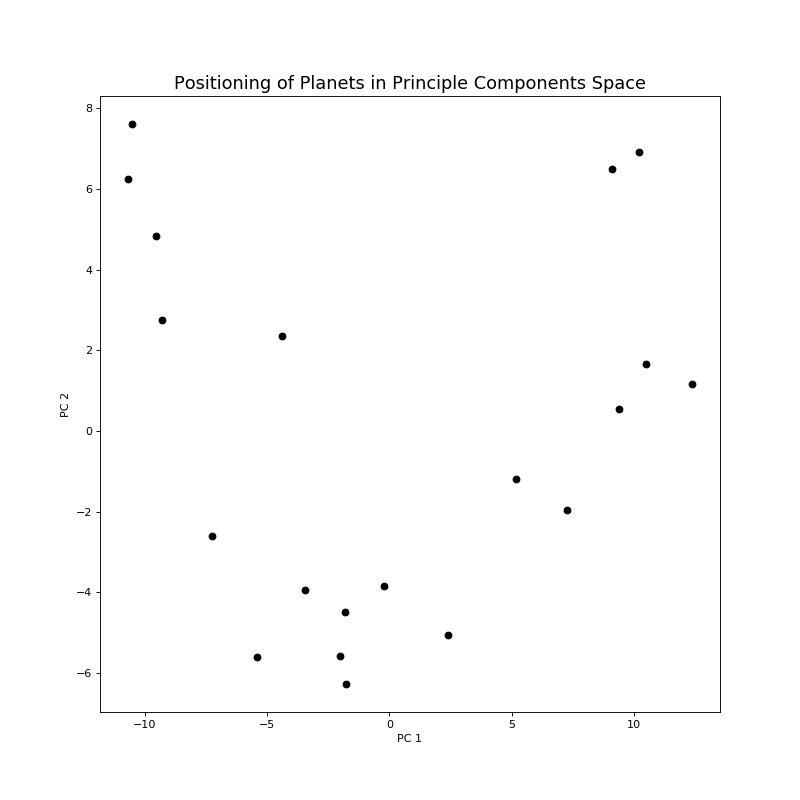

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


In [71]:
d_name = ['PC 1', 'PC 2']
x = projected[:, 0]
y = projected[:, 1]
img_array
planethoverScatter(x,y,img_array, title='Positioning of Planets in Principle Components Space', d_name=d_name)


### unlike NMF the correlation between pca components should be 0.

In [72]:
sp.stats.pearsonr(projected[:,1], projected[:,0])

(-1.3877787807814457e-16, 0.9999999999999976)

## Principle components are linear combinations of the sensory positions of planets from ideal model

### VIF appears to show that there is some multicolinearity in the model. Nonetheless I'm going to proceed with backward elimination of parameters.

In [73]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df = pd.DataFrame(planets_by_dim[:,(0,1,2,3,4,5)], columns= ['Water','Clouds','Rings','Moons','Blue-green','Red-yellow'])
    
X = add_constant(df)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const         1.866747
Water         9.786301
Clouds        3.321587
Rings         1.303161
Moons         1.353584
Blue-green    6.389315
Red-yellow    1.749355
dtype: float64

### Backward elimination for PC 1

In [74]:
lm(planets_by_dim,projected[:, 0])

adjusted R^2 = 0.919559
p =6
r =20


In [75]:
for i in range(6):
    planetsdim = np.delete(planets_by_dim, i, axis=1)
    lm(planetsdim,projected[:, 0])

adjusted R^2 = 0.759571
p =5
r =20
adjusted R^2 = 0.918771
p =5
r =20
adjusted R^2 = 0.897449
p =5
r =20
adjusted R^2 = 0.922686
p =5
r =20
adjusted R^2 = 0.915473
p =5
r =20
adjusted R^2 = 0.864786
p =5
r =20


In [76]:
for i in range(5):
    planetsdim = np.delete(planets_by_dim[:,(0,1,2,4,5)], i, axis=1)
    lm(planetsdim,projected[:, 0])

adjusted R^2 = 0.759491
p =4
r =20
adjusted R^2 = 0.921892
p =4
r =20
adjusted R^2 = 0.902215
p =4
r =20
adjusted R^2 = 0.919215
p =4
r =20
adjusted R^2 = 0.849488
p =4
r =20


In [77]:
for i in range(4):
    planetsdim = np.delete(planets_by_dim[:,(0,2,4,5)], i, axis=1)
    lm(planetsdim,projected[:, 0])

adjusted R^2 = 0.591550
p =3
r =20
adjusted R^2 = 0.901199
p =3
r =20
adjusted R^2 = 0.915437
p =3
r =20
adjusted R^2 = 0.850780
p =3
r =20


In [78]:
for i in range(3):
    planetsdim = np.delete(planets_by_dim[:,(0,2,5)], i, axis=1)
    lm(planetsdim,projected[:, 0])

adjusted R^2 = 0.113895
p =2
r =20
adjusted R^2 = 0.904650
p =2
r =20
adjusted R^2 = 0.840904
p =2
r =20


In [79]:
for i in range(2):
    planetsdim = np.delete(planets_by_dim[:,(0,5)], i, axis=1)
    lm(planetsdim,projected[:, 0])

adjusted R^2 = 0.035047
p =1
r =20
adjusted R^2 = 0.836559
p =1
r =20


In [80]:
lm(planets_by_dim[:,0:1],projected[:, 0])

adjusted R^2 = 0.836559
p =1
r =20


In [81]:
lm(planets_by_dim[:,0].reshape(-1,1),projected[:, 0])

adjusted R^2 = 0.836559
p =1
r =20


### Backward elimination for PC 2

In [82]:
lm(planets_by_dim,projected[:, 1])

adjusted R^2 = 0.712545
p =6
r =20


In [83]:
for i in range(6):
    planetsdim = np.delete(planets_by_dim, i, axis=1)
    lm(planetsdim,projected[:, 1])

adjusted R^2 = 0.407707
p =5
r =20
adjusted R^2 = 0.700479
p =5
r =20
adjusted R^2 = 0.516678
p =5
r =20
adjusted R^2 = 0.727625
p =5
r =20
adjusted R^2 = 0.352628
p =5
r =20
adjusted R^2 = 0.623444
p =5
r =20


In [84]:
for i in range(5):
    planetsdim = np.delete(planets_by_dim[:,(0,1,2,4,5)], i, axis=1)
    lm(planetsdim,projected[:, 1])

adjusted R^2 = 0.445997
p =4
r =20
adjusted R^2 = 0.715838
p =4
r =20
adjusted R^2 = 0.545255
p =4
r =20
adjusted R^2 = 0.383916
p =4
r =20
adjusted R^2 = 0.602283
p =4
r =20


In [85]:
for i in range(4):
    planetsdim = np.delete(planets_by_dim[:,(0,2,4,5)], i, axis=1)
    lm(planetsdim,projected[:, 1])

adjusted R^2 = 0.430809
p =3
r =20
adjusted R^2 = 0.535752
p =3
r =20
adjusted R^2 = 0.419355
p =3
r =20
adjusted R^2 = 0.591605
p =3
r =20


In [86]:
lm(planets_by_dim[:,0:1],projected[:, 1])

adjusted R^2 = -0.036773
p =1
r =20


So in theory, the ML people could generate a model that learns to predicts  humans sensory perceptions from pixel data. Then, for a novel planet, it computes its position in sensory space and measures the distance to the ideal to determine the relative importance.


Of note but not included here. I also computed helling distance and determined if the pc are linear combo of a planets distance to the ideal on each dimension. unsurprisingly, water was signficiant. This was predictable of course because the ideal resides high on water so if PC1 is linear combo of water on sensory then it should also be on preference. A more interesting question is what will happen if the ideal is most strongly influenced by a dimension on which it finds itslef in the moderate range. It would be interesting to see how pca and nmf ight deal with this.

I intend to simulate data with this property to test the ideal models ability to recover ground truth parameters. I also intend to explore performance of pca and nmf with this simulated data.